# Programa para deducir la matriz de rigidez de un elemento de pórtico de Timoshenko-Ehrenfest a partir de la solución de la ecuación diferencial

El elemento finito de pórtico, y sus funciones de forma asociadas, se deducen mediante la solución del siguiente conjunto de ecuaciones diferenciales:

* Por el EF de viga:
\begin{align*}
 \frac{\text{d} V(x)}{\text{d} x}      &= q(x) \\
 \frac{\text{d} M(x)}{\text{d} x}      &= V(x) - m(x) \\
 \frac{\text{d} \theta(x)}{\text{d} x} &= \frac{M(x)}{E(x)I(x)} \\
 \frac{\text{d} w(x)}{\text{d} x}      &= \theta(x)-\frac{V(x)}{\alpha G(x)A(x)}
\end{align*}

* Por el EF de barra:
\begin{align*}
\frac{\text{d} u(x)}{\text{d} x} &= \frac{f_{\text{axial}}(x)}{E(x)A(x)} \\
\frac{\text{d} f_{\text{axial}}(x)}{\text{d} x} &= - b(x)
\end{align*}

Para tal fin se calcula la solución homogénea de dichas ecuaciones diferenciales, es decir, haciendo $q = b = m = 0$.

La ventaja principal de este EF es que no solo satisface la solución exacta, sino que también, está libre del fenómeno del bloqueo por cortante.

In [1]:
import sympy as sp

# Para imprimir bonito
sp.init_printing()

from IPython.display import Math                 
def imprimir (texto, variable, grande=False):
    if grande:
        return Math(texto + r'\large{' + rf'{sp.latex(sp.simplify(variable))}' + '}')
    else:
        return Math(texto +  rf'{sp.latex(sp.simplify(variable))}')

In [2]:
# Definción de variables
x, xi, L, EI, beta, b, m, EA = sp.symbols('x xi L EI beta b m EA')

# Se define beta como beta = (12 * EI)/(L**2 * GAast)
GAast = (12 * EI)/(L**2 * beta)

# Se define la carga: hace la ecuación diferencial homogénea
q = b = m = 0

## 1. Cálculo de la matriz de rigidez $\boldsymbol{K}_{TE}$

Recordemos que $\beta = \frac{12  EI}{L^2  GA^*}$ es el *factor de influencia por cortante*. En la viga de Euler-Bernoulli $\beta = 0$.

Las funciones de forma se determinan al satisfacer la ecuación diferencial homogenea de las ecuaciones estáticas.

### 1.1. Método 1

In [3]:
# Se definen las constantes de integración
C1, C2, C3, C4, C5, C6 = sp.symbols('C_1:7')

# Se plantea la ecuación diferencial
V =  sp.integrate(q, x)           + C1  # Ecuaciones calculadas con constantes.
M =  sp.integrate(V - m, x)       + C2
t =  (sp.integrate(M, x)          + C3)/EI
w =  sp.integrate(t - V/GAast, x) + C4
A = -sp.integrate(b, x)           + C5  # fuerza axial
u =  sp.integrate(A/EA, x)        + C6

# Se calcula la matrix de rigidez
K_TE = sp.zeros(6)
N_u = sp.zeros(1,6)
N_w = sp.zeros(1,6)
N_t = sp.zeros(1,6)
for i in range(6):
    sol = sp.solve([u.subs(x, 0) - int((i == 0)),
                    w.subs(x, 0) - int((i == 1)),  # Condiciones de frontera
                    t.subs(x, 0) - int((i == 2)),
                    u.subs(x, L) - int((i == 3)),
                    w.subs(x, L) - int((i == 4)),
                    t.subs(x, L) - int((i == 5))],
                    [C1, C2, C3, C4, C5, C6])

    constantes = [(C1, sol[C1]), (C2, sol[C2]), (C3, sol[C3]), (C4, sol[C4]), (C5, sol[C5]), (C6, sol[C6])]
    
    sol_A  = A.subs(constantes)
    sol_V  = V.subs(constantes)
    sol_M  = M.subs(constantes)
    N_u[i] = u.subs(constantes)
    N_w[i] = w.subs(constantes)
    N_t[i] = t.subs(constantes)

    # se evaluan las reacciones horizontales y verticales y los momentos en los apoyos
    K_TE[:, i] = [- sol_A.subs(x, 0),   # X1
                  + sol_V.subs(x, 0),   # Y1
                  - sol_M.subs(x, 0),   # M1
                  + sol_A.subs(x, L),   # X2
                  - sol_V.subs(x, L),   # Y2
                  + sol_M.subs(x, L)]   # M2

# Se convierten las funciones de forma a coordenadas naturales
N_u = sp.simplify(N_u.subs(x, L*(1+xi)/2))
N_w = sp.simplify(N_w.subs(x, L*(1+xi)/2))  # x = L*xi/2 + L/2
N_t = sp.simplify(N_t.subs(x, L*(1+xi)/2))
    
# Se imprime la solución
imprimir(r'\boldsymbol{K}_{TE} = ', K_TE)

<IPython.core.display.Math object>

### 1.2. Método 2

In [4]:
# Se definen las funciones
A = sp.Function('A')(x)
V = sp.Function('V')(x)
M = sp.Function('M')(x)
u = sp.Function('u')(x)
w = sp.Function('w')(x)
t = sp.Function('theta')(x)
    
# Se calcula la matrix de rigidez
K_TE2 = sp.zeros(6)
N_u2 = sp.zeros(1,6)
N_w2 = sp.zeros(1,6)
N_t2 = sp.zeros(1,6)
for i in range(6):
    sol = sp.dsolve(eq=[  sp.diff(V,x) - 0,
                          sp.diff(M,x) - V + m,
                          sp.diff(t,x) - M/EI,
                          sp.diff(w,x) - t + V/GAast,
                          sp.diff(A,x) + b,
                          sp.diff(u,x) - A/EA ],
                    ics={ u.subs(x, 0): int((i == 0)),
                          w.subs(x, 0): int((i == 1)),
                          t.subs(x, 0): int((i == 2)),
                          u.subs(x, L): int((i == 3)),
                          w.subs(x, L): int((i == 4)),
                          t.subs(x, L): int((i == 5)) })
    
    VV      = sol[0].rhs
    MM      = sol[1].rhs
    N_t2[i] = sol[2].rhs
    N_w2[i] = sol[3].rhs
    AA      = sol[4].rhs
    N_u2[i] = sol[5].rhs
    
    # se evaluan las reacciones horizontales y verticales y los momentos en los apoyos
    K_TE2[:, i] = [- AA.subs(x, 0),   # X1 
                   + VV.subs(x, 0),   # Y1 
                   - MM.subs(x, 0),   # M1
                   + AA.subs(x, L),   # X1 
                   - VV.subs(x, L),   # Y2
                   + MM.subs(x, L)]   # M2

# Se convierten las funciones de forma a coordenadas naturales
N_u2 = sp.simplify(N_u2.subs(x, L*(1+xi)/2))
N_w2 = sp.simplify(N_w2.subs(x, L*(1+xi)/2))  # x = L*xi/2 + L/2
N_t2 = sp.simplify(N_t2.subs(x, L*(1+xi)/2))

# Se imprime la solución
imprimir(r'\boldsymbol{K}_{TE} = ', K_TE2)

<IPython.core.display.Math object>

### 1.3. Se verifica que ambos métodos dan la misma respuesta

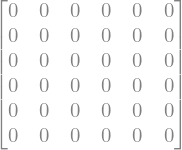

In [5]:
sp.simplify(K_TE - K_TE2)

In [6]:
sp.simplify(N_u - N_u2)

In [7]:
sp.simplify(N_w - N_w2)

In [8]:
sp.simplify(N_t - N_t2)

## 2. Se imprimen las funciones de forma "exactas" del EF de Timoshenko-Ehrenfest

In [9]:
imprimir(r'\boldsymbol{N}_{u}(\xi) = ', N_u)

<IPython.core.display.Math object>

In [10]:
imprimir(r'\boldsymbol{N}_{w}(\xi) = ', N_w)

<IPython.core.display.Math object>

In [11]:
imprimir(r'\boldsymbol{N}_{\theta}(\xi) = ', N_t)

<IPython.core.display.Math object>

## 3. Cálculo de la matriz de rigidez de la teoría de Euler-Bernoulli $\boldsymbol{K}_{EB}$
Observe que cuando $GA^* \to \infty$ (o alternativamente $\beta \to 0$), la matriz de rigidez $\boldsymbol{K}_{TE}$ se vuelve la misma matriz de rigidez $\boldsymbol{K}_{EB}$ de la teoría de Euler-Bernoulli:

In [12]:
K_EB = K_TE.limit(beta, 0)

# Se imprime la solución
imprimir(r'\boldsymbol{K}_{EB} = ', K_EB)

<IPython.core.display.Math object>

## 4. Cálculo del vector de fuerzas nodales equivalentes asociados a una carga vertical trapezoidal

In [13]:
# Se define la carga distribuida vertical
b1, b2, q1, q2 = sp.symbols('b_1 b_2 q_1 q_2')
m = 0                                   # no incluya momentos por unidad de longitud
b = (b2 - b1)*x/L + b1
q = (q2 - q1)*x/L + q1

# Se plantea la ecuación diferencial
V =  sp.integrate(q, x)           + C1  # Ecuaciones calculadas con constantes.
M =  sp.integrate(V - m, x)       + C2
t =  (sp.integrate(M, x)          + C3)/EI
w =  sp.integrate(t - V/GAast, x) + C4
A = -sp.integrate(b, x)           + C5  # fuerza axial
u =  sp.integrate(A/EA, x)        + C6

# Se resuelven las constantes de la ecuación diferencial
sol = sp.solve([ u.subs(x, 0),
                 w.subs(x, 0),  # Condiciones de frontera
                 t.subs(x, 0),
                 u.subs(x, L),
                 w.subs(x, L),
                 t.subs(x, L) ],
               [C1, C2, C3, C4, C5, C6])

constantes = [(C1, sol[C1]), (C2, sol[C2]), (C3, sol[C3]), (C4, sol[C4]), (C5, sol[C5]), (C6, sol[C6])]
    
sol_A  = A.subs(constantes)
sol_V  = V.subs(constantes)
sol_M  = M.subs(constantes)

# se evaluan las reacciones horizontales y verticales y los momentos en los apoyos
f_TE = sp.Matrix([[+ sol_A.subs(x, 0),   # X1
                   - sol_V.subs(x, 0),   # Y1
                   + sol_M.subs(x, 0),   # M1
                   - sol_A.subs(x, L),   # X2
                   + sol_V.subs(x, L),   # Y2
                   - sol_M.subs(x, L)]]).T # M2

# Se imprime el vector de fuerzas nodales equivalentes para la viga de Timoshenko-Ehrenfest:
tmp = L
imprimir(r'\boldsymbol{f}_{TE} = L', f_TE/tmp, grande=True)

<IPython.core.display.Math object>

Se imprime el vector de fuerzas nodales equivalentes para la viga de Euler-Bernoulli:

In [14]:
f_EB = f_TE.limit(beta,0)
tmp = L
imprimir(r'\boldsymbol{f}_{EB} = L', f_EB/tmp, grande=True)

<IPython.core.display.Math object>

## 5. Se calcula la matriz de masa consistente $\boldsymbol{M}$

La matriz de masa se separa en dos clases de matrices:
\begin{equation*}
\boldsymbol{M} = \boldsymbol{M}_{\rho A} +  \boldsymbol{M}_{\rho I}
\end{equation*}

La matriz $\boldsymbol{M}_{\rho A}$ es la asociada a la inercia translacional

La matriz $\boldsymbol{M}_{\rho I}$ es la asociada a la inercia rotacional. Aquí $I$ es el momento de inercia alrededor del eje de rotación, que en este caso es la fibra neutra de la viga. 

Ver:
* https://en.wikipedia.org/wiki/Moment_of_inertia
* https://en.wikipedia.org/wiki/Rotational_energy

### Se calcula la matriz de masa asociada a la inercia translacional $\boldsymbol{M}_{\rho A}$

In [15]:
rho, A = sp.symbols('rho A')
N = sp.Matrix.vstack(N_u, N_w)
M_TE_rhoA = sp.integrate(rho*A*N.T*N * L/2, (xi, -1, 1))

tmp = rho*A*L/(210 * (1 + beta)**2)
imprimir(r'\boldsymbol{M}_{TE,\rho A} = \frac{\rho A L}{210 (1+\beta)^2}', M_TE_rhoA/tmp)

<IPython.core.display.Math object>

In [16]:
M_EB_rhoA = M_TE_rhoA.limit(beta, 0)
tmp = rho*A*L/420
imprimir(r'\boldsymbol{M}_{EB,\rho A} = \frac{\rho A L}{420}', M_EB_rhoA/tmp)

<IPython.core.display.Math object>

### Se calcula la matriz de masa asociada a la inercia rotacional $\boldsymbol{M}_{\rho I}$

In [17]:
rho, I = sp.symbols('rho I')
N = sp.Matrix.vstack(N_t)
M_TE_rhoI = sp.integrate(rho*I*N.T*N * L/2, (xi, -1, 1))

tmp = rho*I/(30*L*(1 + beta)**2)
imprimir(r'\boldsymbol{M}_{TE,\rho I} = \frac{\rho I}{30 (1+\beta)^2 L}', M_TE_rhoI/tmp)

<IPython.core.display.Math object>

Es importante anotar que la matriz de inercia rotacional $\boldsymbol{M}_{EB,\rho I}$ usualmente se desprecia en la teoría de Euler-Bernoulli; cuando se incluye este efecto la viga de Euler-Bernoulli se convierte en la llamada viga de Rayleigh:

In [18]:
M_EB_rhoI = M_TE_rhoI.limit(beta, 0)
tmp = rho*I/(30*L)
imprimir(r'\boldsymbol{M}_{EB,\rho I} = \frac{\rho I}{30 L}', M_EB_rhoI/tmp)

<IPython.core.display.Math object>

## 6. Nota final

Los resultados aquí mostrados han sido verificados con las siguientes publicaciones:
Nota: los resultados se verificaron con los artículos:
* Z. Friedman, J.B. Kosmatka (1993) - An improved two-node timoshenko beam finite element. Computers & Structures, Volume 47, Issue 3, Pages 473-481. https://doi.org/10.1016/0045-7949(93)90243-7.
* B. S. Gan (2018) - An Isogeometric Approach to Beam Structures: Bridging the Classical to Modern Technique. Springer. Capítulo 3. https://link.springer.com/book/10.1007/978-3-319-56493-7